In [1]:
# QAOA CODE CREDITS: https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html

### Overview of The Quantum Approximate Optimization Algorithm

The QAOA algorithm is one of the more commonly-known variational hybrid quantum-classical algorithms to date. The reason its referenced so much in literature is because of its potential for near-term quantum advantage. QAOA is known to solve graph problems, which has a variety of applications in the field of combinatorial optimization, like the travelling sales man problem, and the Maximum Cut problem

QAOA is very similar to VQE, in the way that it uses a paramterized quantum circuit and some form of classical optimization to optimize our problem hamiltonian. Here' We'll explain QAOA in terms of a simple unweighted Max-Cut problem. A Max-Cut problem involes a graph in which we want to "colour" each node so to increase the cut of the overall graph. If two differently coloured nodes are connected, we get +1 to the cut (in an un-weighted example).

### QAOA uses two types of hamiltonians to achieve our desired solution.
### 1. $H_C$

This hamiltonian is the we use to encode our cost function. In the case of QAOA, we often use the "Ising Model" to describe our problem. The Ising Model is described as: $H(\sigma) = - \sum_{<i,j>} J_{ij}\sigma_i\sigma_j$

$\sigma_i$ and $\sigma_j$ represents the spin of the i'th and j'th particles in a system (up + or down -), and $J_{ij} $ represents the strength of the interaction between these two particles. 

In the case of Max-Cut, the $\sigma_i, \sigma_j$ terms will be our nodes, and the $J_{ij}$ term will represent the cut between them.

Therefore, the ising model will represent our cost hamiltonian, $H_C$

### 2. $H_B$

Although the previous hamiltonian encodes the cost function, this is as critical to make QAOA work. This hamiltonian is a much simpler hamiltonian, who should not commute with $H_C$. $H_B$ is important because it allows us to change to expressibility of our ansatz, which allows us to escape local minima. $H_B$ can be described as:

$H_B = \sum^n_{j=0} \sigma_j^x$


### What the circuit looks like
Now that we have both hamiltonians needed to create our QAOA, we need to encode them into our circuit. We construct our unitary operators:

$U(H_C, \gamma) = e^{-i\gamma H_C} $ and $U(H_B, \beta) = e^{-i\beta H_B}$,

So, we create the state $|\gamma,\beta\rangle =(H_C, \gamma_p)(H_B, \beta_p)... (H_C, \gamma_1)(H_B, \beta_1)|s\rangle$, where $|s\rangle$ is our initall state, usually $|000..0\rangle$ or $| +++...+\rangle$

We implement this circuit p times, and run it. Once we read out our values we update parameter $\gamma, \beta$ with classical optimization and repeat until we reach our desired state.

### Steps of QAOA
1. Define $H_C$ and $H_B$
2. Encode our hamiltonians into circuit form $p$ times
3. Evaluate cost + readout values to classical computer
4. Update parameters $\gamma,\beta$ 
5. Feed updated parameters back into the circuit
6. Repeat steps 2-5 until convergence.

At the end of the algorithm, the results should be encoded into a bitstring, which represents the colour of each node. e.g. 0 = blue, 1 = red.

In [2]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting + Other
import matplotlib.pyplot as plt
import math
import networkx as nx
import time

### CHOOSE A GRAPH TO MAXCUT

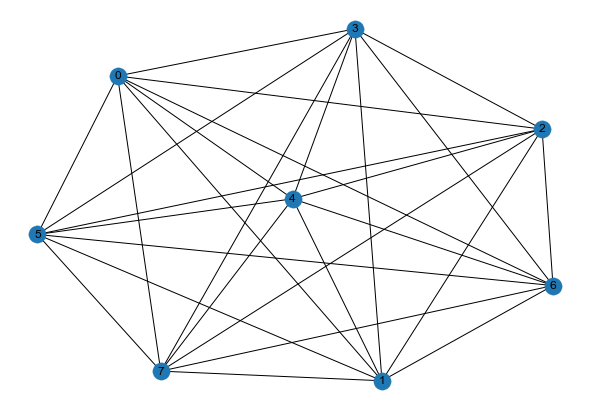

In [72]:
#insert # of nodes here
n_nodes = 8
n_wires = n_nodes


'''    8 NODES    '''
#all-to-all
graph = [(0, 1), (0, 2), (1, 3), (0, 3), (1, 2), (2, 3), (0,4), (1,4), (2,4), (3,4), (0,5), (1,5), (2,5), (3,5), (4,5), (0,6), (1,6), (2,6), (3,6), (4,6), (5,6), (0,7), (1,7), (2,7), (3,7), (4,7), (5,7), (6,7)]

#nearest neighbour
#graph = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (0,7), (6,7)]

#random
#graph = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7)]





'''    7 NODES    '''
#all-to-all
#graph = [(0, 1), (0, 2), (1, 3), (0, 3), (1, 2), (2, 3), (0,4), (1,4), (2,4), (3,4), (0,5), (1,5), (2,5), (3,5), (4,5), (0,6), (1,6), (2,6), (3,6), (4,6), (5,6)]

#nearest neighbour
#graph = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (0,6)]

#random
#graph = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6)]


'''    6 NODES    '''
######### all-to-all
#graph = [(0, 1), (0, 2), (1, 3), (0, 3), (1, 2), (2, 3), (0,4), (1,4), (2,4), (3,4), (0,5), (1,5), (2,5), (3,5), (4,5)]
######### nearest neighbour  
#graph = [(0,1), (1,2), (2,3), (3,4), (4,5),(0,5)]

#graph = [(0,1), (0,2), (0,3), (0,4), (0,5)]

'''    5 NODES    '''
########## all-to-all
#graph = [(0, 1), (0, 2), (1, 3), (0, 3), (1, 2), (2, 3), (0,4), (1,4), (2,4), (3,4)]

########## nearest neighbour
#graph = [(0, 1), (0, 4), (1,2), (2,3), (3,4)]

########## #random graph 
#graph = [(0, 1), (0, 3), (1, 2), (2, 3), (2,0), (3,1)]
#graph = [(0,1), (0,2), (0,3), (0,4)]
#graph = [(0,1), (0,4), (4,3), (4,2), (2,3), (3,1), (4,1)]



'''   4 NODES   '''
########## all-to-all
#graph = [(0, 1), (0, 3), (1, 2), (2, 3), (2,0), (3,1)]

########## nearest neighbour
#graph = [(0, 1), (0, 3), (1, 2), (2, 3)]


########## #random graph 
#graph = [(0,1), (0,2), (0,3)]



graph_visual = nx.Graph(graph)
nx.draw(graph_visual, with_labels=True)

### DEFINE MIXER AND DRIVER

In [73]:
# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])


In [74]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [75]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [76]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

### DEFINE AND RUN QAOA

In [77]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, 2)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:08b}".format(most_freq_bit_string))
    most_freq_bit_string = format(most_freq_bit_string, '08b')
    print(most_freq_bit_string)

    
    return -objective(params), bit_strings, most_freq_bit_string


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
t = time.time()
bitstring = qaoa_maxcut(n_layers=2)
bitstrings1 = bitstring[1]
t = time.time() - t


p=2
Objective after step     5:  8.0747713
Objective after step    10:  13.6675213
Objective after step    15:  13.7343038
Objective after step    20:  13.9797311
Objective after step    25:  14.0244506
Objective after step    30:  14.3222267
Optimized (gamma, beta) vectors:
[[-1.55209667 -0.80678164]
 [ 0.75179002 -1.46971437]]
Most frequently sampled bit string is: 01100011
01100011


In [78]:
print('{:5f}'.format(t))

2784.972460


### PLOT SAMPLES

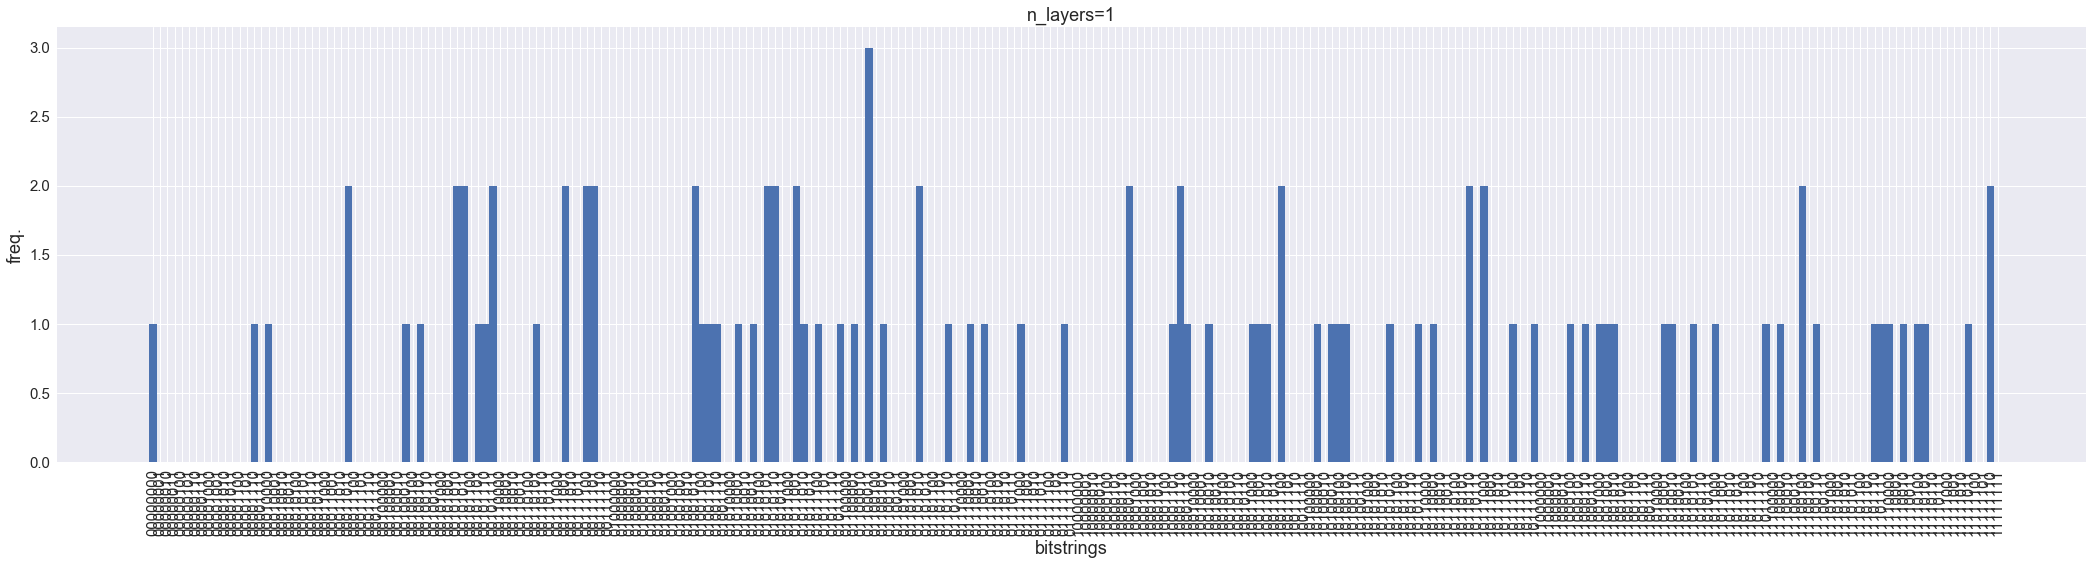

In [79]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
xticks = range(0, pow(2,n_nodes))

xtick_labels = list(map(lambda x: format(x, "08b"), xticks))

bins = np.arange(0, pow(2,n_nodes)) - 0.5

fig,ax1 = plt.subplots(1, figsize=(80, 8))
plt.subplot(1, 2, 1)
plt.title("n_layers=1", fontsize=18)
plt.xlabel("bitstrings",fontsize=18)
plt.ylabel("freq.", fontsize=18)
plt.xticks(xticks, xtick_labels, rotation="vertical", fontsize=15)
plt.yticks(fontsize=15)
plt.hist(bitstrings1, bins=bins)
plt.show()

### VISUALIZING THE CUT

01100011


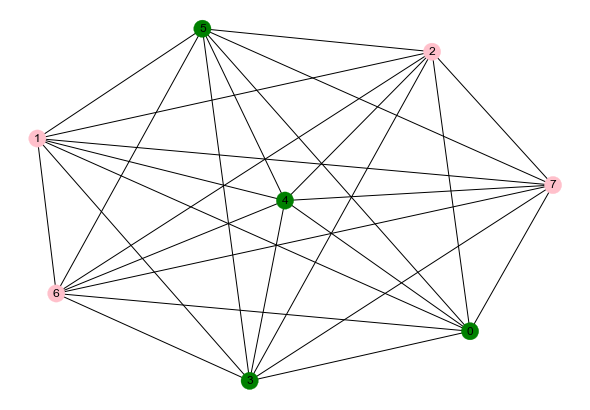

In [80]:
most_freq = bitstring[2]
print(most_freq)

colour_map = []

for bit in most_freq:
    if bit == '1':
        colour_map.append('pink')
    else:
        colour_map.append('green')
        
nx.draw(graph_visual, node_color=colour_map, with_labels=True)

In [46]:
#print(bitstring[1])